In [1]:
# path to src code
%cd ../..

c:\Users\olarinoyem\Project\Multivate-forecasting


In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.io as pio
from itertools import cycle
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from tqdm.autonotebook import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
import shutil
from src.utils import plotting_utils
from src.dl.dataloaders import TimeSeriesDataModule
from src.dl.multivariate_models import SingleStepRNNConfig, SingleStepRNNModel
import os
import warnings
from plotly.subplots import make_subplots
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from scipy.stats import spearmanr

# Set default plotly template
pio.templates.default = "plotly_white"

# For reproduceability set a random seed
pl.seed_everything(42)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Ignore warnings
warnings.filterwarnings("ignore")

# Enable progress apply for pandas
tqdm.pandas()

# Set torch float32 matmul precision to high
torch.set_float32_matmul_precision("high")

C:\Users\olarinoyem\AppData\Local\Temp\ipykernel_3576\2598270644.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Seed set to 42


In [3]:
def format_plot(
    fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15
):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text=ylabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text=xlabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
    )
    return fig


def mase(actual, predicted, insample_actual):
    mae_insample = np.mean(np.abs(np.diff(insample_actual)))
    mae_outsample = np.mean(np.abs(actual - predicted))
    return mae_outsample / mae_insample


def forecast_bias(actual, predicted):
    return np.mean(predicted - actual)


def plot_forecast(
    pred_df, forecast_columns, forecast_display_names=None, save_path=None
):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)

    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = px.colors.qualitative.Set2  # Using a different color palette
    act_color = colors[0]
    colors = cycle(colors[1:])

    fig = go.Figure()

    # Actual data plot
    fig.add_trace(
        go.Scatter(
            x=pred_df[mask].index,
            y=pred_df[mask].covidOccupiedMVBeds,
            mode="lines",
            marker=dict(size=6, opacity=0.5),
            line=dict(color=act_color, width=2),
            name="Actual COVID-19 MVBeds trends",
        )
    )

    # Predicted data plot
    for col, display_col in zip(forecast_columns, forecast_display_names):
        fig.add_trace(
            go.Scatter(
                x=pred_df[mask].index,
                y=pred_df.loc[mask, col],
                mode="lines+markers",
                marker=dict(size=4),
                line=dict(color=next(colors), width=2),
                name=display_col,
            )
        )

    return fig


def highlight_abs_min(s, props=""):
    return np.where(s == np.nanmin(np.abs(s.values)), props, "")

In [4]:
if not os.path.exists("../images"):
    os.mkdir("../images")

In [5]:
data = pd.read_csv("data/processed/merged_nhs_covid_data.csv").drop("Unnamed: 0", axis=1).reset_index(drop=True)
data.head()

,areaCode,areaName,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,latitude,longitude,epi_week
0,E40000007,East of England,2022-09-12,9.0,84162,418.0,47,505.0,2.0,2177579.0,19129.0,6235410,52.24,0.41,202237
1,E40000007,East of England,2022-09-11,8.0,84115,421.0,46,429.0,3.0,2177074.0,19127.0,6235410,52.24,0.41,202237
2,E40000007,East of England,2022-09-10,8.0,84069,419.0,34,296.0,0.0,2176645.0,19124.0,6235410,52.24,0.41,202236
3,E40000007,East of England,2022-09-09,9.0,84035,411.0,34,308.0,2.0,2176349.0,19124.0,6235410,52.24,0.41,202236
4,E40000007,East of England,2022-09-08,9.0,84001,421.0,51,335.0,3.0,2176041.0,19122.0,6235410,52.24,0.41,202236


In [6]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8054 entries, 0 to 8053
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   areaCode              8054 non-null   object        
 1   areaName              8054 non-null   object        
 2   date                  8054 non-null   datetime64[ns]
 3   covidOccupiedMVBeds   8054 non-null   float64       
 4   cumAdmissions         8054 non-null   int64         
 5   hospitalCases         8054 non-null   float64       
 6   newAdmissions         8054 non-null   int64         
 7   new_confirmed         8054 non-null   float64       
 8   new_deceased          8054 non-null   float64       
 9   cumulative_confirmed  8054 non-null   float64       
 10  cumulative_deceased   8054 non-null   float64       
 11  population            8054 non-null   int64         
 12  latitude              8054 non-null   float64       
 13  longitude         

In [7]:
data.columns

Index(['areaCode', 'areaName', 'date', 'covidOccupiedMVBeds', 'cumAdmissions',
       'hospitalCases', 'newAdmissions', 'new_confirmed', 'new_deceased',
       'cumulative_confirmed', 'cumulative_deceased', 'population', 'latitude',
       'longitude', 'epi_week'],
      dtype='object')

In [8]:
# check the unique values in the areaName column
data['areaName'].unique()

array(['East of England', 'London', 'Midlands',
       'North East and Yorkshire', 'North West', 'South East',
       'South West'], dtype=object)

In [9]:
# Filter data between the specified dates
data_filtered = data[(data["date"] >= "2020-01-01") & (data["date"] <= "2021-12-31")]

# Metrics to plot
metrics = [
    "covidOccupiedMVBeds",
    "hospitalCases",
    "newAdmissions",
    "new_confirmed",
    "new_deceased",
]

# Create a subplot for each metric
fig = make_subplots(
    rows=len(metrics),
    cols=1,
    shared_xaxes=True,
    # subplot_titles=[metric.replace("_", " ").title() for metric in metrics],
)

# Plot data for each region and each metric
for i, metric in enumerate(metrics):
    for j, (region, group) in enumerate(data_filtered.groupby("areaName")):
        show_legend = i == 0  # Only show legend for the first metric
        fig.add_trace(
            go.Scatter(
                x=group["date"],
                y=group[metric],
                mode="lines",
                name=region,
                showlegend=show_legend,
            ),
            row=i + 1,
            col=1,
        )

# Update layout
fig.update_layout(
    height=1200,
    width=1000,
    title_text="COVID-19 Data Visualization by Region",
    template="plotly_white",
    legend=dict(y=1, x=1.5, yanchor="top", xanchor="right", orientation="h"),
)

# Update x-axis and y-axis labels
fig.update_xaxes(title_text="Date", row=len(metrics), col=1)
for i, metric in enumerate(metrics):
    fig.update_yaxes(title_text=metric.replace("_", " ").title(), row=i + 1, col=1)

# Show the figure
fig.show()

In [10]:
# flip the data, so it will start from the first date for each region
data_filtered = data_filtered.sort_values(by=["date", "areaName"]).reset_index(drop=True)
data_filtered.head()

,areaCode,areaName,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,latitude,longitude,epi_week
0,E40000007,East of England,2020-04-01,0.0,1400,833.0,167,334.0,75.0,2938.0,455.0,6235410,52.24,0.410000,202014
1,E40000003,London,2020-04-01,0.0,7651,4219.0,767,977.0,189.0,11086.0,1566.0,8982256,51.50,-0.083333,202014
2,E40000008,Midlands,2020-04-01,0.0,5104,2192.0,776,301.0,44.0,2294.0,259.0,4811065,52.98,-0.750000,202014
3,E40000008,Midlands,2020-04-01,0.0,5104,2192.0,776,411.0,108.0,4234.0,721.0,5907872,52.47,-2.290000,202014
4,E40000009,North East and Yorkshire,2020-04-01,0.0,2765,1293.0,507,307.0,32.0,1478.0,152.0,2656980,55.00,-1.866667,202014


In [11]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   areaCode              5760 non-null   object        
 1   areaName              5760 non-null   object        
 2   date                  5760 non-null   datetime64[ns]
 3   covidOccupiedMVBeds   5760 non-null   float64       
 4   cumAdmissions         5760 non-null   int64         
 5   hospitalCases         5760 non-null   float64       
 6   newAdmissions         5760 non-null   int64         
 7   new_confirmed         5760 non-null   float64       
 8   new_deceased          5760 non-null   float64       
 9   cumulative_confirmed  5760 non-null   float64       
 10  cumulative_deceased   5760 non-null   float64       
 11  population            5760 non-null   int64         
 12  latitude              5760 non-null   float64       
 13  longitude         

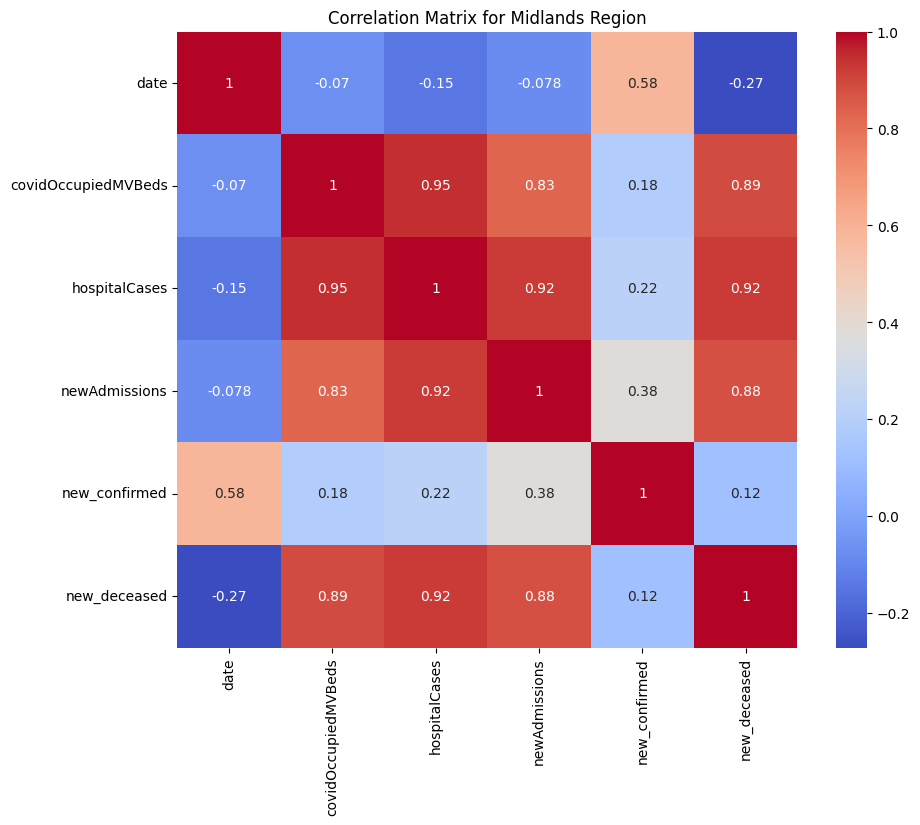

In [12]:
# select midlands region data and do a correlation analysis
midlands_data = data_filtered[data_filtered["areaName"] == "Midlands"]
midlands_data.drop(["areaName", "areaCode", "cumAdmissions","cumulative_confirmed", "cumulative_deceased", "population", "latitude", "longitude", "epi_week"], axis=1, inplace=True)
# Calculate the correlation matrix
correlation_matrix = midlands_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for Midlands Region")
# plt.savefig("../images/correlation_matrix.png")
plt.show()

- Lockdown 1 (march23, 2020 - july 4, 2020)
- lockdown 2 (Novmeber 5, 2020 - December 2, 2020)
- lockdown 3 (january 6, 2020 - aril12, 2020)


In [13]:
# # Lockdown dates for COVID-19 in the UK
# # Note: These dates are general approximations as specific dates might vary slightly

# # The data starts from early 2020, so we'll consider major lockdown periods in the UK since then

# lockdown_dates = {
#     'Lockdown 1': {'start': '2020-03-23', 'end': '2020-07-04'},
#     'Lockdown 2': {'start': '2020-11-05', 'end': '2020-12-02'},
#     'Lockdown 3': {'start': '2021-01-06', 'end': '2021-04-12'}
# }

# # Converting dates to datetime for plotting
# for lockdown in lockdown_dates:
#     lockdown_dates[lockdown]['start'] = pd.to_datetime(lockdown_dates[lockdown]['start'])
#     lockdown_dates[lockdown]['end'] = pd.to_datetime(lockdown_dates[lockdown]['end'])

# # Plotting the trend component with lockdown periods
# plt.figure(figsize=(14, 6))
# plt.plot(trend_hospital_cases, label='Trend of Hospital Cases', color='blue')

# # Adding shaded areas for lockdown periods
# for lockdown in lockdown_dates:
#     plt.axvspan(lockdown_dates[lockdown]['start'], lockdown_dates[lockdown]['end'], color='red', alpha=0.3, label=lockdown)

# plt.xlabel('Date')
# plt.ylabel('Hospital Cases')
# plt.title('Trend of Hospital Cases with Lockdown Periods')
# plt.legend()
# plt.show()


In [14]:
# # Re-loading the data due to code execution state reset
# england_data = pd.read_csv(file_path)
# england_data['date'] = pd.to_datetime(england_data['date'])
# england_data_time_series = england_data.set_index('date')

# # Handling missing values using interpolation
# england_data_time_series_interpolated = england_data_time_series.interpolate()

# # Re-performing seasonal decomposition on 'Hospital Cases' after handling missing values
# decomposition_hospital_cases = seasonal_decompose(england_data_time_series_interpolated['Hospital Cases'], model='additive')

# # Extracting the seasonal and trend components
# seasonal_hospital_cases = decomposition_hospital_cases.seasonal
# trend_hospital_cases = decomposition_hospital_cases.trend

# # Plotting the trend and seasonal components
# plt.figure(figsize=(14, 8))

# plt.subplot(2, 1, 1)
# plt.plot(trend_hospital_cases, label='Trend of Hospital Cases', color='blue')
# plt.title('Trend Component in Hospital Cases')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(seasonal_hospital_cases, label='Seasonal Variation in Hospital Cases', color='green')
# plt.title('Seasonal Component in Hospital Cases')
# plt.legend()

# plt.tight_layout()
# plt.show()


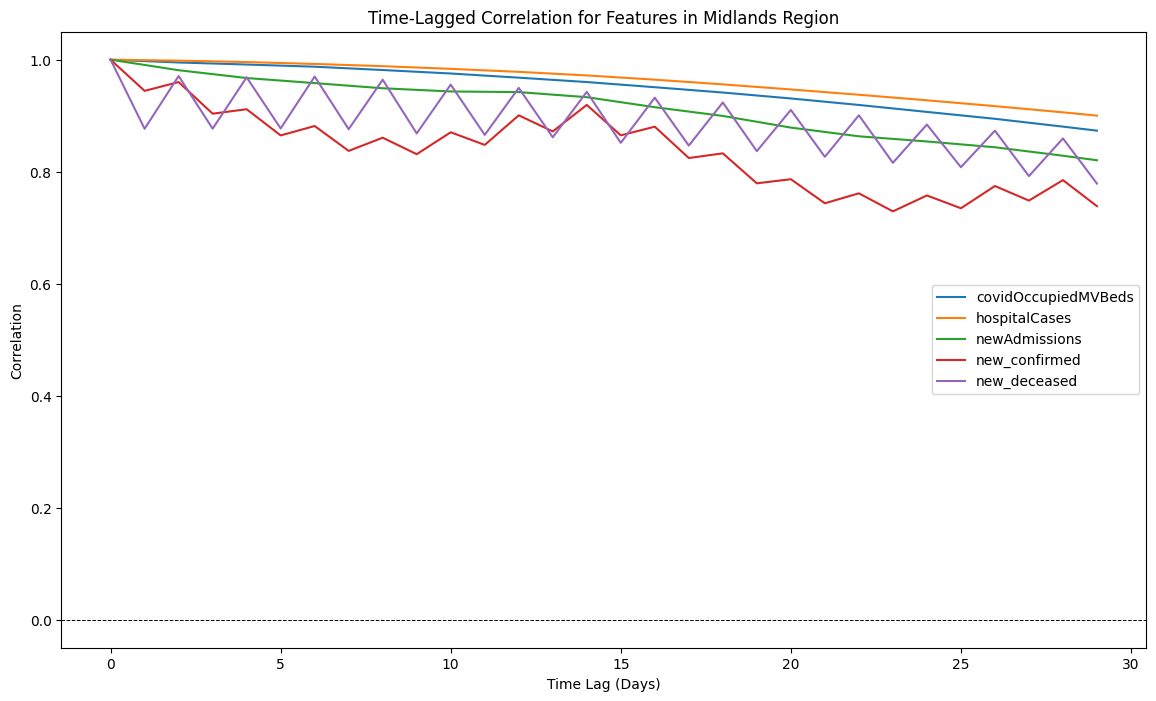

In [15]:
# Time-lagged correlation analysis for ICU beds and the features in the Midlands region
# Select the features to include in the analysis
features = [
    "covidOccupiedMVBeds",
    "hospitalCases",
    "newAdmissions",
    "new_confirmed",
    "new_deceased",
]

# Define the maximum lag period
max_lag = 30

# Calculate the time-lagged correlation for each feature
time_lagged_correlation = {}
for feature in features:
    time_lagged_correlation[feature] = []
    for lag in range(max_lag):
        correlation = midlands_data[feature].corr(midlands_data[feature].shift(lag))
        time_lagged_correlation[feature].append(correlation)
        
# Plot the time-lagged correlation for each feature
plt.figure(figsize=(14, 8))
for feature in features:
    plt.plot(time_lagged_correlation[feature], label=feature)
    
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Time Lag (Days)')
plt.ylabel('Correlation')
plt.title('Time-Lagged Correlation for Features in Midlands Region')
plt.legend()
plt.show()

In [16]:
# Function to calculate the optimal lag for each variable
def optimal_lag(target, features, max_lag):
    optimal_lags = {}
    for feature in features:
        min_error = float('inf')
        best_lag = 0

        for lag in range(1, max_lag + 1):
            # Creating the lagged feature
            temp_df = data.copy()
            temp_df[feature + '_lag'] = temp_df[feature].shift(lag)

            # Dropping missing values (introduced by shifting)
            temp_df = temp_df.dropna()

            # Splitting the dataset
            X = temp_df[[feature + '_lag']]
            y = temp_df[target]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

            # Training the model
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Predicting and calculating the error
            predictions = model.predict(X_test)
            error = mae(y_test, predictions)

            # Checking if this lag results in a lower error
            if error < min_error:
                min_error = error
                best_lag = lag

        optimal_lags[feature] = best_lag

    return optimal_lags

# Defining the target variable and features
target = 'covidOccupiedMVBeds'
features = [
    "hospitalCases",
    "newAdmissions",
    "new_confirmed",
    "new_deceased",
]

# Calculating the optimal lag for each feature
optimal_lags = optimal_lag(target, features, max_lag=30)
optimal_lags



{'hospitalCases': 2, 'newAdmissions': 1, 'new_confirmed': 5, 'new_deceased': 1}

In [17]:
# Define a function to calculate the optimal lag for each variable using Spearman correlation
def optimal_lag_spearman_ml(data, target, features, max_lag, model):
    optimal_lags = {}
    
    # TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    for feature in features:
        best_spearman_corr = 0
        best_lag = 0

        for lag in range(1, max_lag + 1):
            # Create a lagged feature
            temp_data = data.copy()
            temp_data[feature + '_lag'] = temp_data[feature].shift(lag)
            temp_data.dropna(inplace=True)

            # Cross-validation
            spearman_corrs = []
            for train_index, test_index in tscv.split(temp_data):
                train, test = temp_data.iloc[train_index], temp_data.iloc[test_index]
                
                # Spearman correlation
                corr, _ = spearmanr(train[target], train[feature + '_lag'])
                spearman_corrs.append(corr)

            avg_spearman_corr = np.mean(spearman_corrs)
            if avg_spearman_corr > best_spearman_corr:
                best_spearman_corr = avg_spearman_corr
                best_lag = lag

        optimal_lags[feature] = best_lag

    return optimal_lags

# Define the target variable and features
target = 'covidOccupiedMVBeds'
features = [
    "hospitalCases",
    "newAdmissions",
    "new_confirmed",
    "new_deceased",
]
max_lag_days = 30  # Maximum lag in days to consider

# Find the optimal lag for each feature
optimal_lags = optimal_lag_spearman_ml(midlands_data, target, features, max_lag_days, LinearRegression())

optimal_lags



{'hospitalCases': 2,
 'newAdmissions': 18,
 'new_confirmed': 30,
 'new_deceased': 3}

In [18]:
# create rolling mean statistics for covidOccupiedMVBeds in the Midlands region dataframe using window size of 7 days, 14 and 30 days
midlands_data['covidOccupiedMVBeds_7day_mean'] = midlands_data['covidOccupiedMVBeds'].rolling(window=7).mean()
# midlands_data['covidOccupiedMVBeds_14day_mean'] = midlands_data['covidOccupiedMVBeds'].rolling(window=14).mean()
# midlands_data['covidOccupiedMVBeds_30day_mean'] = midlands_data['covidOccupiedMVBeds'].rolling(window=30).mean()

# Plotting the rolling mean statistics using plotly on a single plot
fig = go.Figure()

# Plotting the actual data
fig.add_trace(go.Scatter(x=midlands_data['date'], y=midlands_data['covidOccupiedMVBeds'], mode='lines', name='Actual Data'))

# Plotting the rolling mean statistics
fig.add_trace(go.Scatter(x=midlands_data['date'], y=midlands_data['covidOccupiedMVBeds_7day_mean'], mode='lines', name='7-Day Rolling Mean'))
# fig.add_trace(go.Scatter(x=midlands_data['date'], y=midlands_data['covidOccupiedMVBeds_14day_mean'], mode='lines', name='14-Day Rolling Mean'))
# fig.add_trace(go.Scatter(x=midlands_data['date'], y=midlands_data['covidOccupiedMVBeds_30day_mean'], mode='lines', name='30-Day Rolling Mean'))

# Updating the layout
fig.update_layout(
    title='Rolling Mean Statistics for COVID-19 Occupied MV Beds in Midlands Region',
    xaxis_title='Date',
    yaxis_title='COVID-19 Occupied MV Beds',
    template='plotly_white'
)

# Showing the plot
fig.show()


In [19]:
class LogTime():
    from time import time
    
    def __enter__(self):
        self.start_time = self.time()
        print("Starting operation...")
        
    def __exit__(self, type, value, traceback):
        elapsed_time = self.time() - self.start_time
        print(f"Operation completed in {elapsed_time} seconds.")

# Define a function to add time-lagged features to the dataset
def add_lags(data, lags, features):
    added_features = []
    for feature in features:
        for lag in lags:
            new_feature = feature + f'_lag_{lag}'
            data[new_feature] = data[feature].shift(lag)
            added_features.append(new_feature)
    return data, added_features


lags = [1]

midlands_data, added_features = add_lags(midlands_data, lags, ['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions', 'new_confirmed', 'new_deceased'])
midlands_data.dropna(inplace=True)

In [20]:
midlands_data['date'] = pd.to_datetime(midlands_data['date'])
midlands_data = midlands_data.set_index('date')
midlands_data.head()

,covidOccupiedMVBeds,hospitalCases,newAdmissions,new_confirmed,new_deceased,covidOccupiedMVBeds_7day_mean,covidOccupiedMVBeds_lag_1,hospitalCases_lag_1,newAdmissions_lag_1,new_confirmed_lag_1,new_deceased_lag_1
date,,,,,,,,,,,
2020-04-04,360.0,2925.0,559,190.0,53.0,239.428571,357.0,2682.0,451.0,372.0,86.0
2020-04-04,360.0,2925.0,559,347.0,107.0,290.857143,360.0,2925.0,559.0,190.0,53.0
2020-04-05,406.0,3091.0,489,148.0,60.0,348.857143,360.0,2925.0,559.0,347.0,107.0
2020-04-05,406.0,3091.0,489,290.0,117.0,363.857143,406.0,3091.0,489.0,148.0,60.0
2020-04-06,419.0,3250.0,439,219.0,68.0,380.714286,406.0,3091.0,489.0,290.0,117.0


In [21]:
from src.transforms.target_transformations import AutoStationaryTransformer

# Set the target variable
target = 'covidOccupiedMVBeds'

# Initialize the AutoStationaryTransformer with a seasonality period
# Adjust the seasonal_period based on your data's seasonality (for example, 7 for weekly seasonality)
seasonal_period = 7
auto_stationary = AutoStationaryTransformer(seasonal_period=seasonal_period)

# Fit and transform the target column to make it stationary
data_stat = auto_stationary.fit_transform(midlands_data[[target]], freq="D")

# Replace the original target values with the transformed stationary values
midlands_data[target] = data_stat.values

# Print the transformed data to check
midlands_data.head()

,covidOccupiedMVBeds,hospitalCases,newAdmissions,new_confirmed,new_deceased,covidOccupiedMVBeds_7day_mean,covidOccupiedMVBeds_lag_1,hospitalCases_lag_1,newAdmissions_lag_1,new_confirmed_lag_1,new_deceased_lag_1
date,,,,,,,,,,,
2020-04-04,27.014743,2925.0,559,190.0,53.0,239.428571,357.0,2682.0,451.0,372.0,86.0
2020-04-04,27.014743,2925.0,559,347.0,107.0,290.857143,360.0,2925.0,559.0,190.0,53.0
2020-04-05,28.611748,3091.0,489,148.0,60.0,348.857143,360.0,2925.0,559.0,347.0,107.0
2020-04-05,28.611748,3091.0,489,290.0,117.0,363.857143,406.0,3091.0,489.0,148.0,60.0
2020-04-06,29.044616,3250.0,439,219.0,68.0,380.714286,406.0,3091.0,489.0,290.0,117.0


In [22]:
midlands_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1274 entries, 2020-04-04 to 2021-12-31
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   covidOccupiedMVBeds            1274 non-null   float64
 1   hospitalCases                  1274 non-null   float64
 2   newAdmissions                  1274 non-null   int64  
 3   new_confirmed                  1274 non-null   float64
 4   new_deceased                   1274 non-null   float64
 5   covidOccupiedMVBeds_7day_mean  1274 non-null   float64
 6   covidOccupiedMVBeds_lag_1      1274 non-null   float64
 7   hospitalCases_lag_1            1274 non-null   float64
 8   newAdmissions_lag_1            1274 non-null   float64
 9   new_confirmed_lag_1            1274 non-null   float64
 10  new_deceased_lag_1             1274 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 119.4 KB


In [23]:
# Get the minimum and maximum date from the data
min_date = midlands_data.index.min()
max_date = midlands_data.index.max()
# Calculate the range of dates
date_range = max_date - min_date
print(f"Data ranges from {min_date} to {max_date} ({date_range.days} days)")

Data ranges from 2020-04-04 00:00:00 to 2021-12-31 00:00:00 (636 days)


In [24]:
# selecting 1 year data for training and 2 months data for validation and 3 months data for testing
train_end = min_date + pd.DateOffset(months=12)
val_end = train_end + pd.DateOffset(months=2)
test_end = val_end + pd.DateOffset(months=3)

# Split the data into training, validation, and testing sets
train = midlands_data[midlands_data.index <= train_end]
val = midlands_data[(midlands_data.index > train_end) & (midlands_data.index <= val_end)]
test = midlands_data[midlands_data.index > val_end]

# Calculate the percentage of dates in each dataset
total_sample = len(midlands_data)
train_sample = len(train) / total_sample * 100
val_sample = len(val) / total_sample * 100
test_sample = len(test) / total_sample * 100

print(f"Train: {train_sample:.2f}%, Validation: {val_sample:.2f}%, Test: {test_sample:.2f}%")
print(f"Train: {len(train)} samples, Validation: {len(val)} samples, Test: {len(test)} samples")
print(f"Max date in train: {train.index.max()}, Min date in validation: {val.index.min()}, Max date in test: {test.index.max()}")


Train: 57.46%, Validation: 9.58%, Test: 32.97%
Train: 732 samples, Validation: 122 samples, Test: 420 samples
Max date in train: 2021-04-04 00:00:00, Min date in validation: 2021-04-05 00:00:00, Max date in test: 2021-12-31 00:00:00


In [25]:
# Concatenate the DataFrames
sample_df = pd.concat([train, val, test])

# Convert all the feature columns to float32
for col in sample_df.columns:
    sample_df[col] = sample_df[col].astype('float32')
    
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1274 entries, 2020-04-04 to 2021-12-31
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   covidOccupiedMVBeds            1274 non-null   float32
 1   hospitalCases                  1274 non-null   float32
 2   newAdmissions                  1274 non-null   float32
 3   new_confirmed                  1274 non-null   float32
 4   new_deceased                   1274 non-null   float32
 5   covidOccupiedMVBeds_7day_mean  1274 non-null   float32
 6   covidOccupiedMVBeds_lag_1      1274 non-null   float32
 7   hospitalCases_lag_1            1274 non-null   float32
 8   newAdmissions_lag_1            1274 non-null   float32
 9   new_confirmed_lag_1            1274 non-null   float32
 10  new_deceased_lag_1             1274 non-null   float32
dtypes: float32(11)
memory usage: 64.7 KB


In [26]:
sample_df.columns

Index(['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions',
       'new_confirmed', 'new_deceased', 'covidOccupiedMVBeds_7day_mean',
       'covidOccupiedMVBeds_lag_1', 'hospitalCases_lag_1',
       'newAdmissions_lag_1', 'new_confirmed_lag_1', 'new_deceased_lag_1'],
      dtype='object')

In [27]:
columns_to_select = [
    "covidOccupiedMVBeds",
    # "hospitalCases",
    # "newAdmissions",
    # "new_confirmed",
    # "new_deceased",
    "covidOccupiedMVBeds_7day_mean",
    "covidOccupiedMVBeds_lag_1",
    "hospitalCases_lag_1",
    "newAdmissions_lag_1",
    "new_confirmed_lag_1",
    "new_deceased_lag_1",
]

In [28]:
sample_df = sample_df[columns_to_select]
sample_df.head()

,covidOccupiedMVBeds,covidOccupiedMVBeds_7day_mean,covidOccupiedMVBeds_lag_1,hospitalCases_lag_1,newAdmissions_lag_1,new_confirmed_lag_1,new_deceased_lag_1
date,,,,,,,
2020-04-04,27.014742,239.428574,357.0,2682.0,451.0,372.0,86.0
2020-04-04,27.014742,290.857147,360.0,2925.0,559.0,190.0,53.0
2020-04-05,28.611748,348.857147,360.0,2925.0,559.0,347.0,107.0
2020-04-05,28.611748,363.857147,406.0,3091.0,489.0,148.0,60.0
2020-04-06,29.044617,380.714294,406.0,3091.0,489.0,290.0,117.0


In [29]:
cols = list(sample_df.columns)
cols.remove("covidOccupiedMVBeds")
sample_df = sample_df[cols + ["covidOccupiedMVBeds"]]

In [30]:
target = "covidOccupiedMVBeds"
pred_df = pd.concat([train[[target]], val[[target]]])

In [31]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1274 entries, 2020-04-04 to 2021-12-31
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   covidOccupiedMVBeds_7day_mean  1274 non-null   float32
 1   covidOccupiedMVBeds_lag_1      1274 non-null   float32
 2   hospitalCases_lag_1            1274 non-null   float32
 3   newAdmissions_lag_1            1274 non-null   float32
 4   new_confirmed_lag_1            1274 non-null   float32
 5   new_deceased_lag_1             1274 non-null   float32
 6   covidOccupiedMVBeds            1274 non-null   float32
dtypes: float32(7)
memory usage: 44.8 KB


In [32]:
datamodule = TimeSeriesDataModule(
    data=sample_df,
    n_val=val.shape[0],
    n_test=test.shape[0],
    window=7,  # 7 days window
    horizon=1,  # single step
    normalize="global",  # normalizing the data
    batch_size=32,
    num_workers=0,
)
datamodule.setup()

In [33]:
# Check a few batches from the training dataloader
train_loader = datamodule.train_dataloader()
for x, y in train_loader:
    print("Input batch shape:", x.shape)
    print("Output batch shape:", y.shape)
    break

Input batch shape: torch.Size([32, 7, 7])
Output batch shape: torch.Size([32, 1, 1])


In [34]:
rnn_config = SingleStepRNNConfig(
    rnn_type="LSTM",
    input_size=7,  # 25 for multivariate time series
    hidden_size=128,  # hidden size of the RNN
    num_layers=10, # number of layers
    bidirectional=True, # bidirectional RNN
    learning_rate=1e-3,
)
model = SingleStepRNNModel(rnn_config)
model.float()

SingleStepRNNModel(
  (rnn): LSTM(7, 128, num_layers=10, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (loss): MSELoss()
)

In [35]:
trainer = pl.Trainer(
    min_epochs=5,
    max_epochs=100,
    accelerator = "gpu",
    callbacks=[pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10)],
)
trainer.fit(model, datamodule)
# Removing artifacts created during training
shutil.rmtree("lightning_logs")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\olarinoyem\Project\Multivate-forecasting\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 3.7 M 
1 | fc   | Linear  | 257   
2 | loss | MSELoss | 0     
---------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.792    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [36]:
predictions = trainer.predict(model, datamodule.test_dataloader())
predictions = torch.cat(predictions).squeeze().detach().numpy()
# De-normalizing the predictions
predictions = predictions * datamodule.train.std + datamodule.train.mean

actuals = test["covidOccupiedMVBeds"].values

assert (
    actuals.shape == predictions.shape
), "Mismatch in shapes between actuals and predictions"

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [37]:
metric_record = []

In [38]:
algorithm_name = rnn_config.rnn_type

metrics = {
    "Algorithm": algorithm_name,
    "MAE": mae(actuals, predictions),
    "MSE": mse(actuals, predictions),
    "MASE": mase(actuals, predictions, train["covidOccupiedMVBeds"].values),
    "Forecast Bias": forecast_bias(actuals, predictions),
}

value_formats = ["{}", "{:.4f}", "{:.4f}", "{:.4f}", "{:.2f}"]
metrics = {
    key: format_.format(value)
    for key, value, format_ in zip(metrics.keys(), metrics.values(), value_formats)
}

pred_df_ = pd.DataFrame({"Vanilla LSTM": predictions}, index=test.index)
pred_df = test.join(pred_df_)

metric_record.append(metrics)
print(metrics)

{'Algorithm': 'LSTM', 'MAE': '1.0494', 'MSE': '1.6681', 'MASE': '4.6753', 'Forecast Bias': '-0.13'}


In [39]:
fig = plot_forecast(
    pred_df,
    forecast_columns=["Vanilla LSTM"],
    forecast_display_names=["Vanilla LSTM"],
)
title = f"Forecasting multivarate COVID-19 MVBeds with {algorithm_name}"
fig = format_plot(fig, title=title)
fig.update_xaxes(
    type="date", range=["2021-10-01", "2021-12-31"], dtick="M1", tickformat="%b %Y"
)
save_path = f"images/forecast_multivarate_{algorithm_name}.png"
# pio.write_image(fig, save_path)
fig.show()

## Simulated annealing tunning

In [40]:
# Define the bounds for parameters
param_bounds = {
    "rnn_type": ["GRU", "LSTM", "RNN"],
    "hidden_size": (32, 128),
    "num_layers": (5, 50),
    "bidirectional": [True, False],
    "learning_rate": (1e-6, 1e-2),
}

# Initial hyperparameters and temperature
initial_params = ["GRU", 32, 5, True, 1e-2]
initial_temp = 100


In [41]:
def objective(params):
    rnn_type, hidden_size, num_layers, bidirectional, learning_rate = params
    input_size = 7  # 25 for multivariate time series

    rnn_config = SingleStepRNNConfig(
        rnn_type=rnn_type,
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        bidirectional=bidirectional,
        learning_rate=learning_rate,
    )
    model = SingleStepRNNModel(rnn_config)

    # Training the model using PyTorch Lightning
    trainer = pl.Trainer(
        max_epochs=100,
        accelerator = "gpu",
        callbacks=[pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10)],
    )
    trainer.fit(model, datamodule)
    
    shutil.rmtree("lightning_logs")

    predictions = trainer.predict(model, datamodule.test_dataloader())
    predictions = torch.cat(predictions).squeeze().detach().numpy()
    # De-normalizing the predictions
    predictions = predictions * datamodule.train.std + datamodule.train.mean

    actuals = test["covidOccupiedMVBeds"].values

    assert (
        actuals.shape == predictions.shape
    ), "Mismatch in shapes between actuals and predictions"
    
    mae_score = mae(actuals, predictions)
    
    return mae_score



In [42]:
# Neighbor function to generate a new candidate solution
def neighbor(params):
    rnn_type, hidden_size, num_layers, bidirectional, learning_rate = params

    # Perturbations
    hidden_size = np.random.randint(*param_bounds["hidden_size"])
    num_layers = np.random.randint(*param_bounds["num_layers"])
    learning_rate = np.random.uniform(*param_bounds["learning_rate"])
    rnn_type = np.random.choice(param_bounds["rnn_type"])
    bidirectional = bool(
        np.random.choice(param_bounds["bidirectional"])
    )  # Convert to native boolean

    return [rnn_type, hidden_size, num_layers, bidirectional, learning_rate]


# Cooling schedule (geometric cooling)
def cooling(temp, step):
    return temp * 0.99

In [43]:
def simulated_annealing(initial_params, initial_temp, steps):
    current_params = initial_params
    current_cost = objective(current_params)
    temp = initial_temp
    costs = [current_cost]
    temperatures = [initial_temp]

    for step in range(steps):
        new_params = neighbor(current_params)
        new_cost = objective(new_params)

        # Acceptance criterion
        if new_cost < current_cost or np.random.uniform(0, 1) < np.exp(
            (current_cost - new_cost) / temp
        ):
            current_params, current_cost = new_params, new_cost

        temp = cooling(temp, step)
        costs.append(current_cost)
        temperatures.append(temp)  # Track temperatures

    return current_params, costs, temperatures

In [44]:
# Run Simulated Annealing
best_params, costs, temperatures = simulated_annealing(
    initial_params, initial_temp, 100
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 83.1 K
1 | fc   | Linear  | 65    
2 | loss | MSELoss | 0     
---------------------------------
83.2 K    Trainable params
0         Non-trainable params
83.2 K    Total params
0.333     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 4.0 M 
1 | fc   | Linear  | 167   
2 | loss | MSELoss | 0     
---------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.184    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 2.1 M 
1 | fc   | Linear  | 115   
2 | loss | MSELoss | 0     
---------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.349     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 161 K 
1 | fc   | Linear  | 56    
2 | loss | MSELoss | 0     
---------------------------------
161 K     Trainable params
0         Non-trainable params
161 K     Total params
0.648     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 2.8 M 
1 | fc   | Linear  | 123   
2 | loss | MSELoss | 0     
---------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.207    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | RNN     | 808 K 
1 | fc   | Linear  | 107   
2 | loss | MSELoss | 0     
---------------------------------
808 K     Trainable params
0         Non-trainable params
808 K     Total params
3.235     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 7.1 M 
1 | fc   | Linear  | 247   
2 | loss | MSELoss | 0     
---------------------------------
7.1 M     Trainable params
0         Non-trainable params
7.1 M     Total params
28.265    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | RNN     | 284 K 
1 | fc   | Linear  | 173   
2 | loss | MSELoss | 0     
---------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.139     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 148 K 
1 | fc   | Linear  | 50    
2 | loss | MSELoss | 0     
---------------------------------
148 K     Trainable params
0         Non-trainable params
148 K     Total params
0.594     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | RNN     | 97.1 K
1 | fc   | Linear  | 41    
2 | loss | MSELoss | 0     
---------------------------------
97.1 K    Trainable params
0         Non-trainable params
97.1 K    Total params
0.388     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 481 K 
1 | fc   | Linear  | 40    
2 | loss | MSELoss | 0     
---------------------------------
481 K     Trainable params
0         Non-trainable params
481 K     Total params
1.927     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 56.6 K
1 | fc   | Linear  | 36    
2 | loss | MSELoss | 0     
---------------------------------
56.6 K    Trainable params
0         Non-trainable params
56.6 K    Total params
0.226     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 328 K 
1 | fc   | Linear  | 36    
2 | loss | MSELoss | 0     
---------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.315     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | RNN     | 691 K 
1 | fc   | Linear  | 94    
2 | loss | MSELoss | 0     
---------------------------------
691 K     Trainable params
0         Non-trainable params
691 K     Total params
2.766     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 2.3 M 
1 | fc   | Linear  | 94    
2 | loss | MSELoss | 0     
---------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.136     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 3.5 M 
1 | fc   | Linear  | 169   
2 | loss | MSELoss | 0     
---------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.014    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 159 K 
1 | fc   | Linear  | 77    
2 | loss | MSELoss | 0     
---------------------------------
159 K     Trainable params
0         Non-trainable params
159 K     Total params
0.640     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | RNN     | 297 K 
1 | fc   | Linear  | 65    
2 | loss | MSELoss | 0     
---------------------------------
297 K     Trainable params
0         Non-trainable params
297 K     Total params
1.190     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | RNN     | 356 K 
1 | fc   | Linear  | 79    
2 | loss | MSELoss | 0     
---------------------------------
356 K     Trainable params
0         Non-trainable params
356 K     Total params
1.426     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 3.9 M 
1 | fc   | Linear  | 145   
2 | loss | MSELoss | 0     
---------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.758    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 3.0 M 
1 | fc   | Linear  | 159   
2 | loss | MSELoss | 0     
---------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.949    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | RNN     | 1.5 M 
1 | fc   | Linear  | 151   
2 | loss | MSELoss | 0     
---------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.908     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 648 K 
1 | fc   | Linear  | 79    
2 | loss | MSELoss | 0     
---------------------------------
648 K     Trainable params
0         Non-trainable params
648 K     Total params
2.596     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | RNN     | 522 K 
1 | fc   | Linear  | 91    
2 | loss | MSELoss | 0     
---------------------------------
522 K     Trainable params
0         Non-trainable params
522 K     Total params
2.091     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | RNN     | 4.0 M 
1 | fc   | Linear  | 243   
2 | loss | MSELoss | 0     
---------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.026    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 4.4 M 
1 | fc   | Linear  | 167   
2 | loss | MSELoss | 0     
---------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.684    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 604 K 
1 | fc   | Linear  | 47    
2 | loss | MSELoss | 0     
---------------------------------
604 K     Trainable params
0         Non-trainable params
604 K     Total params
2.417     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 6.4 M 
1 | fc   | Linear  | 205   
2 | loss | MSELoss | 0     
---------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.496    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 355 K 
1 | fc   | Linear  | 38    
2 | loss | MSELoss | 0     
---------------------------------
355 K     Trainable params
0         Non-trainable params
355 K     Total params
1.422     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 8.5 M 
1 | fc   | Linear  | 213   
2 | loss | MSELoss | 0     
---------------------------------
8.5 M     Trainable params
0         Non-trainable params
8.5 M     Total params
34.040    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | RNN     | 113 K 
1 | fc   | Linear  | 59    
2 | loss | MSELoss | 0     
---------------------------------
113 K     Trainable params
0         Non-trainable params
113 K     Total params
0.454     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 532 K 
1 | fc   | Linear  | 41    
2 | loss | MSELoss | 0     
---------------------------------
532 K     Trainable params
0         Non-trainable params
532 K     Total params
2.131     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 343 K 
1 | fc   | Linear  | 56    
2 | loss | MSELoss | 0     
---------------------------------
343 K     Trainable params
0         Non-trainable params
343 K     Total params
1.373     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 3.2 M 
1 | fc   | Linear  | 187   
2 | loss | MSELoss | 0     
---------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.848    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 1.3 M 
1 | fc   | Linear  | 88    
2 | loss | MSELoss | 0     
---------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.034     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 10.2 M
1 | fc   | Linear  | 237   
2 | loss | MSELoss | 0     
---------------------------------
10.2 M    Trainable params
0         Non-trainable params
10.2 M    Total params
40.688    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 2.7 M 
1 | fc   | Linear  | 85    
2 | loss | MSELoss | 0     
---------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.864    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 2.6 M 
1 | fc   | Linear  | 199   
2 | loss | MSELoss | 0     
---------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.203    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | RNN     | 2.3 M 
1 | fc   | Linear  | 201   
2 | loss | MSELoss | 0     
---------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | RNN     | 208 K 
1 | fc   | Linear  | 105   
2 | loss | MSELoss | 0     
---------------------------------
208 K     Trainable params
0         Non-trainable params
208 K     Total params
0.834     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | RNN     | 608 K 
1 | fc   | Linear  | 135   
2 | loss | MSELoss | 0     
---------------------------------
608 K     Trainable params
0         Non-trainable params
608 K     Total params
2.435     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 1.7 M 
1 | fc   | Linear  | 103   
2 | loss | MSELoss | 0     
---------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.714     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 3.9 M 
1 | fc   | Linear  | 143   
2 | loss | MSELoss | 0     
---------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.524    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print("Best parameters found:", best_params)

Best parameters found: ['GRU', 61, 21, False, 0.0053437404078321045]


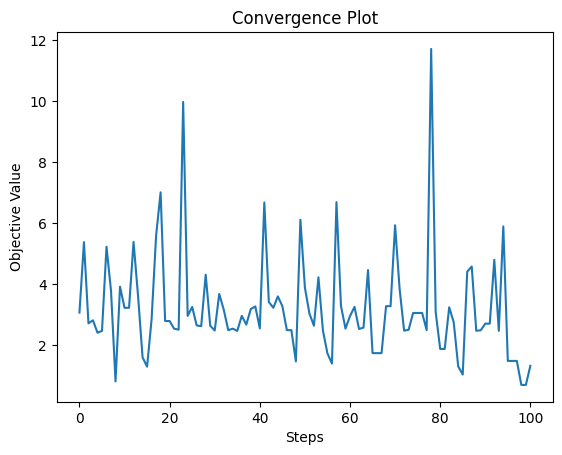

In [ ]:
plt.plot(costs)
plt.xlabel("Steps")
plt.ylabel("Objective Value")
plt.title("Convergence Plot")
plt.show()

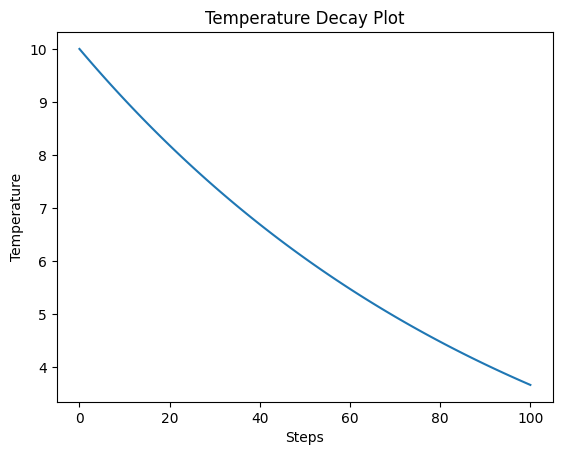

In [ ]:
plt.plot(temperatures)
plt.xlabel("Steps")
plt.ylabel("Temperature")
plt.title("Temperature Decay Plot")
plt.show()

In [ ]:
# Training the model using the best hyperparameters
rnn_type, hidden_size, num_layers, bidirectional, learning_rate = best_params
input_size = 7 # 25 for multivariate time series

rnn_config = SingleStepRNNConfig(
    rnn_type=rnn_type,
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    bidirectional=bidirectional,
    learning_rate=learning_rate,
)
model = SingleStepRNNModel(rnn_config)

# Training the model using PyTorch Lightning
trainer = pl.Trainer(
    max_epochs=100,
    accelerator = "gpu",
    callbacks=[pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10)],
)
trainer.fit(model, datamodule)

shutil.rmtree("lightning_logs")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | GRU     | 466 K 
1 | fc   | Linear  | 62    
2 | loss | MSELoss | 0     
---------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.867     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
predictions = trainer.predict(model, datamodule.test_dataloader())
predictions = torch.cat(predictions).squeeze().detach().numpy()

# De-normalizing the predictions
predictions = predictions * datamodule.train.std + datamodule.train.mean

actuals = test["covidOccupiedMVBeds"].values

assert (
    actuals.shape == predictions.shape
), "Mismatch in shapes between actuals and predictions"

algorithm_name = rnn_config.rnn_type

metrics = {
    "Algorithm": f"{algorithm_name} (SA)",
    "MAE": mae(actuals, predictions),
    "MSE": mse(actuals, predictions),
    "MASE": mase(actuals, predictions, train["covidOccupiedMVBeds"].values),
    "Forecast Bias": forecast_bias(actuals, predictions),
}

value_formats = ["{}", "{:.4f}", "{:.4f}", "{:.4f}", "{:.2f}"]

metrics = {
    key: format_.format(value)
    for key, value, format_ in zip(metrics.keys(), metrics.values(), value_formats)
}

pred_df_ = pd.DataFrame({f"{algorithm_name} (SA)": predictions}, index=test.index)
pred_df = test.join(pred_df_)

metric_record.append(metrics)

print(metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

{'Algorithm': 'GRU (SA)', 'MAE': '8.8448', 'MSE': '94.1376', 'MASE': '39.4064', 'Forecast Bias': '8.39'}


In [ ]:
# Plotting the forecast
fig = plot_forecast(
    pred_df,
    forecast_columns=[f"{algorithm_name} (SA)"],
    forecast_display_names=[algorithm_name],
)

title = f"Forecasting multivarate COVID-19 MVBeds with {algorithm_name} (SA)"

fig = format_plot(fig, title=title)
fig.update_xaxes(
    type="date", range=["2021-10-01", "2021-12-31"], dtick="M1", tickformat="%b %Y"
)

save_path = f"images/forecast_multivarate_{algorithm_name}_sa.png"
# pio.write_image(fig, save_path)
fig.show()

In [ ]:
metric_df = pd.DataFrame(metric_record)
metric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Algorithm      2 non-null      object
 1   MAE            2 non-null      object
 2   MSE            2 non-null      object
 3   MASE           2 non-null      object
 4   Forecast Bias  2 non-null      object
dtypes: object(5)
memory usage: 208.0+ bytes


In [ ]:
metric_df[["MAE", "MSE", "MASE", "Forecast Bias"]] = metric_df[
    ["MAE", "MSE", "MASE", "Forecast Bias"]
].astype("float32")

In [ ]:
formatted = metric_df.style.format(
    {
        "MAE": "{:.4f}",
        "MSE": "{:.4f}",
        "MASE": "{:.4f}",
        "Forecast Bias": "{:.2f}%",
        "Time Elapsed": "{:.6f}",
    }
)
formatted = formatted.highlight_min(
    color="lightgreen", subset=["MAE", "MSE", "MASE"]
).apply(
    highlight_abs_min,
    props="color:black;background-color:lightgreen",
    axis=0,
    subset=["Forecast Bias"],
)
formatted

,Algorithm,MAE,MSE,MASE,Forecast Bias
0,LSTM,0.7549,0.9416,3.3632,-0.04%
1,GRU (SA),8.8448,94.1376,39.4064,8.39%
